In [1]:
import json

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

In [2]:
import numpy as np
np.random.seed(10)

from nltk.corpus import stopwords

import tensorflow as tf

import keras

In [6]:
train = pd.read_csv('../data/train.csv')

In [8]:
# Dropping the data which have NaN

train.dropna(subset=['question1', 'question2', 'is_duplicate'], inplace=True)

## Vanilla Approach

In [10]:
# Identifying number of positive and negative examples in the training data set.

train_pos = train[train['is_duplicate'] == 1]
train_neg = train[train['is_duplicate'] == 0]
print('Number of positive example:', len(train_pos))
print('Number of negative example:', len(train_neg))

Number of positive example: 149263
Number of negative example: 255025


In [27]:
from sklearn.model_selection import train_test_split

# Splitting training dataset into training and validation dataset, in ratio 9:1

X_trainq1, X_validq1, X_trainq2, X_validq2, y_train, y_valid = train_test_split(train['question1'], train['question2'], train['is_duplicate'], test_size=0.1, random_state=1)

print('Train size:', len(y_train))
print('Test size:', len(y_valid))
print('(training : validation) = ', round(len(y_train)/len(y_valid)),' : 1')



Train size: 363859
Test size: 40429
(training : validation) =  9  : 1


In [35]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer(num_words=25000)

# fit the traing text using the tokenizer. 
t.fit_on_texts(X_trainq1.tolist() + X_trainq2.tolist())

len(t.word_index)
#print(t.word_index)

91066

<p> 
<font color='green'>print(t.word_index) prints something like this: each word is converted into a numerical
</font>
</p>

<p> 
<font color='blue'>{'the': 1, 'what': 2, 'is': 3, 'how': 4, 'i': 5, 'a': 6, 'to': 7, 'in': 8, 'do': 9, 'of': 10, 'are': 11, 'and': 12, 'can': 13, 'for': 14, 'you': 15, 'why': 16, 'my': 17, 'best': 18, 'it': 19, 'on': 20, 'does': 21, 'or': 22, 'which': 23, 'be': 24, 'if': 25, 'some': 26, 'have': 27, 'that': 28, 'with': 29, 'get': 30, 'should': 31, 'an': 32, 'from': 33, 'your': 34, 'india': 35, 'will': 36, 'when': 37, 'people': 38, 'who': 39, 'like': 40, 'at': 41, 'good': 42, 'would': 43, 'there': 44, 'as': 45, 'about': 46, 'not': 47, 'between': 48, 'one': 49, 'most': 50, 'we': 51, 'make': 52, 'quora': 53, 'way': 54, 'did': 55, 'where': 56, 'by': 57, 'any': 58, 'me': 59, 'was': 60, 'life': 61, 'so': 62, 'after': 63, 'time': 64, 'this': 65, 'they': 66, 'money': 67, 'know': 68, 'difference': 69, 'has': 70, 'learn': 71, 'am': 72, 'new': 73, "what's": 74, 'use': 75,
</font>
</p>

<p> 
<font color='red'>Once fit, the Tokenizer provides 4 attributes that you can use to query what has been learned about your documents:
<p>
word_counts: A dictionary of words and their counts.
</p>
<p>
word_docs: A dictionary of words and how many documents each appeared in.
</p>
<p>
word_index: A dictionary of words and their uniquely assigned integers.
</p>
<p>
document_count:An integer count of the total number of documents that were used to fit the Tokenizer.
</p>
</font>
</p>


In [36]:
# The indicates, how many times each other appears for the data from training set.
word_cnt = t.word_counts.values()


In [37]:
# Ignoring words with word_cnt <= 5
np.count_nonzero(np.array(list(word_cnt)) > 5)

26783

/home/arjun/venvs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Probability')

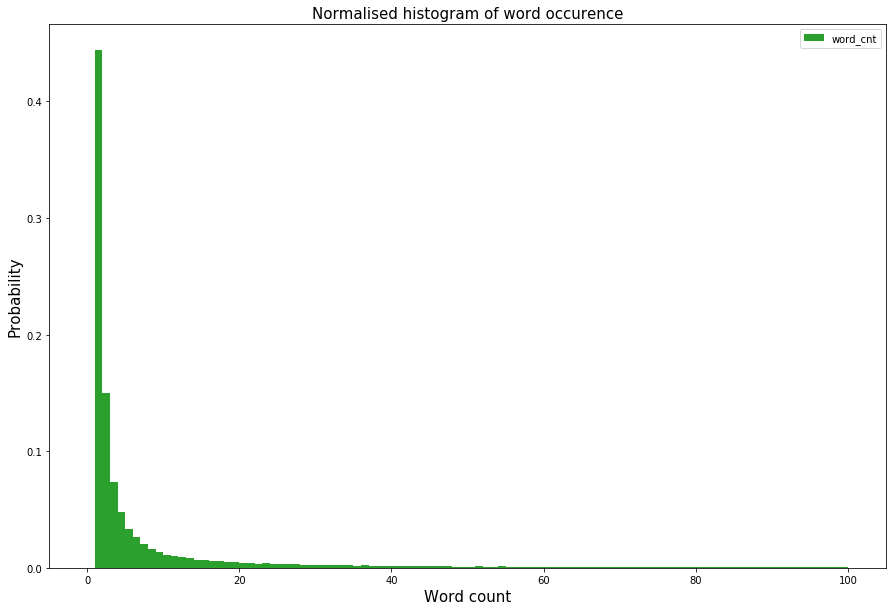

In [75]:
plt.figure(figsize=(15, 10))
plt.hist(word_cnt, bins=100, range=[0, 100], color=pal[2], normed=True, label='word_cnt')
plt.title('Normalised histogram of word occurence', fontsize=15)
plt.legend()
plt.xlabel('Word count', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [38]:
# What is the inference of the above plot?

### Prep training data

In [39]:
X_trainq1_vec = t.texts_to_sequences(X_trainq1)
X_trainq2_vec = t.texts_to_sequences(X_trainq2)

In [75]:
# Q2: Why is size of a particular question's text not matching the size of its vector when converted to sequence using texts_to_sequences? 
print(X_trainq2[78885])
print(X_trainq2_vec[3])
# Answer to Q2: because trainq2 is a dictonary, 78885 is hash of 3rd index in it. But X_trainq2_vec is a 2D array 

What does the hammer and sickle represent?
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     2    21     1  7350    12
 14741  2822]


In [51]:
from keras.preprocessing import sequence

<font color='blue'>
pad_sequences is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.</font>

In [52]:
X_trainq1_vec = sequence.pad_sequences(X_trainq1_vec, maxlen=50)
X_trainq2_vec = sequence.pad_sequences(X_trainq2_vec, maxlen=50)

In [53]:
print('Train Q1 shape:', X_trainq1_vec.shape)
print('Train Q2 shape:', X_trainq2_vec.shape)
print('Train Label shape:', y_train.shape)

Train Q1 shape: (363859, 50)
Train Q2 shape: (363859, 50)
Train Label shape: (363859,)


### Prep validation data

In [60]:
X_validq1_vec = t.texts_to_sequences(X_validq1)
X_validq2_vec = t.texts_to_sequences(X_validq2)

In [76]:
#print(X_trainq1)

In [77]:
X_validq1_vec = sequence.pad_sequences(X_validq1_vec, maxlen=50)
X_validq2_vec = sequence.pad_sequences(X_validq2_vec, maxlen=50)

In [78]:
print('valid Q1 shape:', X_validq1_vec.shape)
print('valid Q2 shape:', X_validq2_vec.shape)
print('valid Label shape:', y_valid.shape)

valid Q1 shape: (40429, 50)
valid Q2 shape: (40429, 50)
valid Label shape: (40429,)


# NN

In [79]:
from keras.models import Sequential, Model
from keras.layers import Dense, Merge, Input
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
# fix random seed for reproducibility
# np.random.seed(7)

from keras.callbacks import TensorBoard

In [80]:
max_sentence_len = 50
embedding_dim = 128

In [82]:
q1_input = Input(shape=(max_sentence_len,), dtype='int32', name='q1_input')
q2_input = Input(shape=(max_sentence_len,), dtype='int32', name='q2_input')

<font color='blue'>
Argument input_length: Length of input sequences, when it is constant. This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).
</font>
<p>
<font color='green'>
The output of the Embedding layer is a 2D vector with one embedding for each word in the input sequence of words (input document).

If you wish to connect a Dense layer directly to an Embedding layer, you must first flatten the 2D output matrix to a 1D vector using the Flatten layer.
</font>
</p>

In [83]:
embed = Embedding(input_dim=25000, output_dim=embedding_dim, input_length=max_sentence_len)
embed_q1 = embed(q1_input)
embed_q2 = embed(q2_input)

In [84]:
print(embed_q1)

Tensor("embedding_1/GatherV2:0", shape=(?, 50, 128), dtype=float32)


<p>
<font color='green'>
LSTM - Long Short-Term Memory layer 
</font> </p>
<p>
<font color='green'>
Arguments:
units: Positive integer, dimensionality of the output space.


</font>
</p>

In [85]:
shared_lstm = LSTM(256)

In [87]:
encoded_q1 = shared_lstm(embed_q1)
encoded_q2 = shared_lstm(embed_q2)
print(encoded_q1)

Tensor("lstm_1_2/TensorArrayReadV3:0", shape=(?, 256), dtype=float32)


In [88]:
# transform encoded_q1 to encoded_q2 (inspiration)
trans_q1 = Dense(256, activation='sigmoid', name='transform_mat')(encoded_q1)
print(trans_q1)

Tensor("transform_mat/Sigmoid:0", shape=(?, 256), dtype=float32)


In [93]:
# x = keras.layers.dot([encoded_q1, encoded_q2], axes=-1)
x = keras.layers.dot([trans_q1, encoded_q2], axes=-1)
print(x)
# output = keras.layers.activations.sigmoid(x)
output = Dense(1, activation='sigmoid')(x)

Tensor("dot_2/ExpandDims:0", shape=(?, 1), dtype=float32)


In [90]:
model = Model(inputs=[q1_input, q2_input], outputs=output)

In [91]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [92]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'q1_input_1:0' shape=(?, 50) dtype=int32>, <tf.Tensor 'q2_input_1:0' shape=(?, 50) dtype=int32>]
[<tf.Tensor 'dense_1/Sigmoid:0' shape=(?, 1) dtype=float32>]


In [94]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q1_input (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 128)      3200000     q1_input[0][0]                   
                                                                 q2_input[0][0]                   
__________________________________________________________________________________________________
q2_input (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 256)          394240      embedding_1[0][0]                
          

In [95]:
import time

In [96]:
tensorboard = TensorBoard(log_dir='./logs/{}'.format(time.strftime('%Y-%m-%dT%H-%M-%S', time.localtime())))

In [97]:
model.fit([X_trainq1_vec, X_trainq2_vec], y_train, validation_data=([X_validq1_vec, X_validq2_vec], y_valid), epochs=10, batch_size=1024, callbacks=[tensorboard])

Train on 363859 samples, validate on 40429 samples
Epoch 1/10
363859/363859 [==============================] - 2106s 6ms/step - loss: 0.5605 - acc: 0.7105 - val_loss: 0.5054 - val_acc: 0.7578
Epoch 2/10
363859/363859 [==============================] - 2071s 6ms/step - loss: 0.4707 - acc: 0.7749 - val_loss: 0.4693 - val_acc: 0.7763
Epoch 3/10
297984/363859 [=======================>......] - ETA: 15:35 - loss: 0.4254 - acc: 0.8006

KeyboardInterrupt: 

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))